# Visualizing satellite handovers 

The Starlink gRPC api exposes a `dish_get_obstruction_map` method, following the approach described in CITE_LEO_PAPER we can use the information we gather from polling this method each second to extract the current obstruction map and visualize satellite handovers. The reason this works is the dish is adding a dot (setting a value to 1) in a 123*123 matrix whenever it sees a satellite in that position, whenever the dish is rebooted (using i.e `nine981.reboot`) the matrix is cleared by setting every entry to -1, whenever a satellite is detected entry is set. If we poll the endpoint frequently enough we can observe satellites traces, by comparing values in the matrices we obtain we can detect whether a satellite handover was performed.


$$
A_{t(x)}=
\begin{bmatrix}
-1 & -1 & 1 & -1 & -1 \\
-1 & -1 & -1 & 1 & -1 \\
-1 & -1 & -1 & -1 & -1 \\
-1 & -1 & -1 & -1 & -1 \\
-1 & -1 & -1 & -1 & -1 \\
\end{bmatrix}
B_{t(x+1)}=
\begin{bmatrix}
-1 & -1 & 1 & -1 & -1 \\
-1 & -1 & -1 & 1 & -1 \\
-1 & -1 & -1 & -1 & 1 \\
-1 & -1 & -1 & -1 & -1 \\
-1 & -1 & -1 & -1 & -1 \\
\end{bmatrix}
A+B=
\begin{bmatrix}
-2 & -2 & 2 & -2 & -2 \\
-2 & -2 & -2 & 2 & -2 \\
-2 & -2 & -2 & -2 & 0 \\
-2 & -2 & -2 & -2 & -2 \\
-2 & -2 & -2 & -2 & -2 \\
\end{bmatrix}
$$

Let's assume these matrices come from the endpoints at $t_x$ and $t_{x+1}$ respectively, in the first matrix we have ones in $(0,2)$ and $(1,3)$, in the second one we have ones in $(0,2)$, $(1,3)$, $(2,4)$, this means the new satellite we saw at $t_{x+1}$ is on the same path as the satellites before, thus NO handover was not performed.

$$
A_{t(x)}=
\begin{bmatrix}
-1 & -1 & 1 & -1 & -1 \\
-1 & -1 & -1 & 1 & -1 \\
-1 & -1 & -1 & -1 & -1 \\
-1 & -1 & -1 & -1 & -1 \\
-1 & -1 & -1 & -1 & -1 \\
\end{bmatrix}
B_{t(x+1)}=
\begin{bmatrix}
-1 & -1 & 1 & -1 & -1 \\
-1 & -1 & -1 & 1 & -1 \\
-1 & -1 & -1 & -1 & -1 \\
-1 & -1 & -1 & -1 & -1 \\
1 & -1 & -1 & -1 & -1 \\
\end{bmatrix}
A+B
=
\begin{bmatrix}
-2 & -2 & 2 & -2 & -2 \\
-2 & -2 & -2 & 2 & -2 \\
-2 & -2 & -2 & -2 & -2 \\
-2 & -2 & -2 & -2 & -2 \\
0 & -2 & -2 & -2 & -2 \\
\end{bmatrix}
$$

If instead the new satellite we see at $t_{x+1}$ is in a totally different area an handover must have been performed.

We can observe it is pretty easy to detect whether an handover was performed, it is sufficient to sum the two matrices and check whether the $0$ value (there was -1 before and we currently have 1) is near an entry whose value is $2$ (at $t_{x}$ value was 1 and at $t_{x+1}$ value is $1$. 



First of all we need to write a script to extract obstruction maps from the dish, to achieve this goal we can use the `nine981.get_obstruction_map` function, this returns a json file similar to this:

```json
{'apiVersion': '9',
 'dishGetObstructionMap': {'minElevationDeg': 10.0,
                           'numCols': 123,
                           'numRows': 123,
                           'snr': [-1.0,
                                   -1.0,
                                   -1.0,
                                   1.0,
                                   1.0,
                                   -1.0,
                                   -1.0,
                                   1.0,
                                   1.0,
                                   1.0,
                                   -1.0,
                                   -1.0,
                                   -1.0,
                                   -1.0]}}
```

Thus we can simply extract the values in `map["dishGetObstructionMap"]["snr"]` and use `np.array(map).reshape(123, 123)` to reshape the array into a $123\times123$ matrix.




In [1]:
import os
import time
import nine981

directory = "./obstruction_maps"
os.makedirs(os.path.dirname(directory + "/"), exist_ok=True)


def get_obstruction_maps():
    # amount of seconds to collect maps for
    for i in range(300):
        map = nine981.get_obstruction_map()
        with open(f"{directory}/{int(time.time())}.json", "w+") as f:
            f.write(map)
        time.sleep(1)
    os.exit(0)


if __name__ == "__main__":
    get_obstruction_maps()

KeyboardInterrupt: 

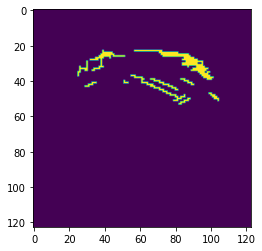

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt

f1 = "../idp-castellotti-data/map-bw-stuff4/1692089163.json"
map = json.load(open(f1))
map = map["dishGetObstructionMap"]["snr"]
map = np.array(map).reshape(123, 123)
plt.imshow(map)
plt.show()

[ ] mention the visualize_handover function in common

now we test the calculate visible sattellites

In [2]:
from common import calculate_visible_satellites

# garching coordinates
observer_latitude = 48.2489
observer_longitude = 11.6532
observer_elevation = 0

visible_satellites = calculate_visible_satellites(
    observer_latitude, observer_longitude, observer_elevation, distance_km=800
)

for sat, alt, az in visible_satellites:
    print(sat.name)
    # print(f"Satellite: {sat}")
    # print(f"Altitude: {alt.degrees} degrees")
    # print(f"Azimuth: {az.degrees} degrees")

STARLINK-1573
STARLINK-3922
STARLINK-4480
STARLINK-4766
STARLINK-5556


# get visible satellites


[]

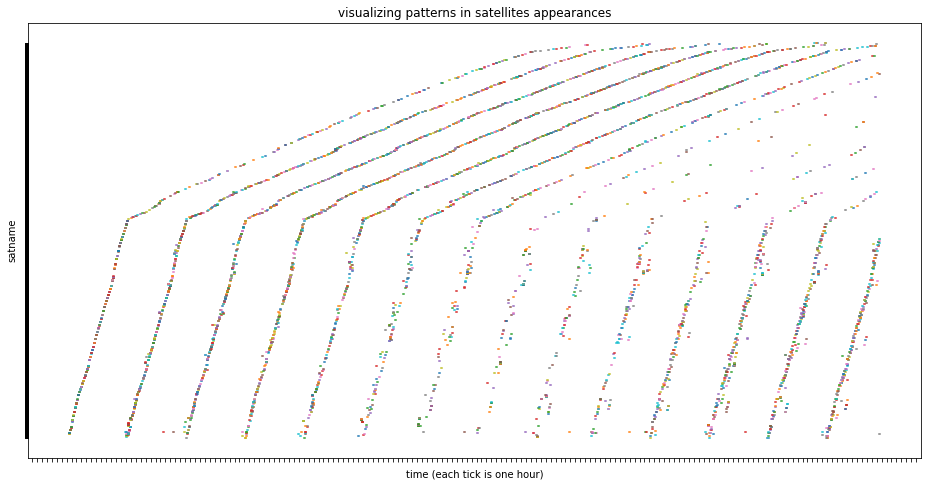

In [ ]:
import sqlite3
from collections import defaultdict
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt


def split_non_consequtive(data):
    data = iter(data)
    val = next(data)
    chunk = []
    try:
        while True:
            chunk.append(val)
            val = next(data)
            if val[0] != chunk[-1][0] + 1:
                yield chunk
                chunk = []
    except StopIteration:
        if chunk:
            yield chunk


cnx = sqlite3.connect("../idp-castellotti-data/satellites.sqlite")
satellites = cnx.execute("SELECT * FROM satellites").fetchall()
sats = defaultdict(list)
for sat in satellites:
    sats[sat[3]].append([sat[1], round(sat[2]), sat[3]])

segments = defaultdict(list)
count = 0
for k in sats:
    if count == 10000:
        break
    count += 1
    for i in split_non_consequtive(sats[k]):
        segments[k].append(
            (datetime.fromtimestamp(i[0][1]), datetime.fromtimestamp(i[-1][1]))
        )

# how long we see satellites for
# for s in random.choices(satellites,k=20):
#     sat=s[3]
#     current_sat=segments[sat]
#     print(sat)
#     for s in current_sat:
#         print(s[1]-s[0])

# we need data in this format: https://stackoverflow.com/a/12291380
plt.figure(figsize=(16, 8))
for y in segments:
    for seg in segments[y]:
        plt.plot(seg, [y, y])
plt.gca().xaxis.set_major_locator(mdates.HourLocator())
plt.gca().axes.xaxis.set_ticklabels([])
plt.gca().axes.yaxis.set_ticklabels([])
plt.ylabel("satname")
plt.xlabel("time (each tick is one hour)")
plt.title("visualizing patterns in satellites appearances")
# plt.savefig("tex/tumbeamer/pics/visualizing-how-long-satellites-are-visible-for.png")
plt.plot()

# amount of satellites we see

In [ ]:
cnx = sqlite3.connect("../idp-castellotti-data/satellites.sqlite")
df = pd.read_sql("select * from satellites", cnx)
df = df[:1000]
df["timestamp"] = pd.to_datetime(df["ts"], unit="s")
plt.figure(figsize=(8, 4))

sns.countplot(df, x="relative_ts", dodge=False)
plt.xlabel("time intervals (15 seconds)")
plt.ylabel("# of visible satellites")
# plt.title('count of visible satellites in 15 seconds intervals')
plt.gca().axes.xaxis.set_ticklabels([])
plt.savefig("tex/tumbeamer/pics/count_visible_satellites.png")
plt.plot()

Now we proceed to check whether we see a correlation between satellite handoves

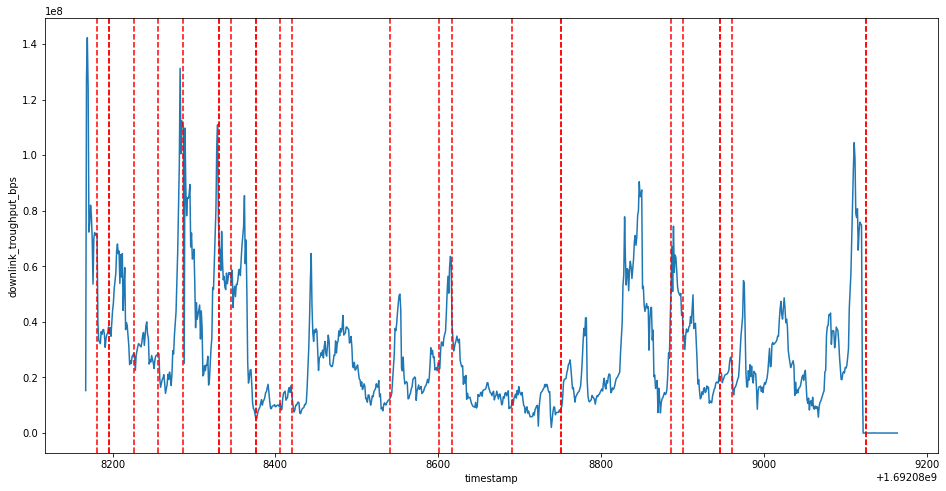

In [ ]:
import os
import seaborn as sns
from common import detect_handovers
import pandas as pd

# glory to chatgpt
def get_adjacent_files(directory):
    file_list = sorted(os.listdir(directory))

    for i, current_file in enumerate(file_list):
        if i > 0:
            previous_file = file_list[i - 1]
        else:
            previous_file = None

        if i < len(file_list) - 1:
            next_file = file_list[i + 1]
        else:
            next_file = None

        yield previous_file, current_file, next_file


handover_unix_timestamps = []
directory_path = "../idp-castellotti-data/map-bw-stuff4"
for previous_file, current_file, next_file in get_adjacent_files(directory_path):
    if previous_file is not None:
        detect_handovers(
            os.path.join(directory_path, previous_file),
            os.path.join(directory_path, current_file),
            handover_unix_timestamps,
        )
    else:
        detect_handovers(
            os.path.join(directory_path, current_file),
            os.path.join(directory_path, next_file),
            handover_unix_timestamps,
        )


df = pd.read_csv("../idp-castellotti-data/map-bw-stuff4.csv")
plt.figure(figsize=(16, 8))
sns.lineplot(data=df, x="timestamp", y="downlink_troughput_bps", dashes=True)


for timestamp in handover_unix_timestamps:
    plt.axvline(x=timestamp, color="r", linestyle="--")

now we want to assess whether the dish buffers packets relayed to satellites, our intuition is that if this is the case we will see a decrease in RTT if we start creating some traffic with a tool like iperf3 on the very same interface

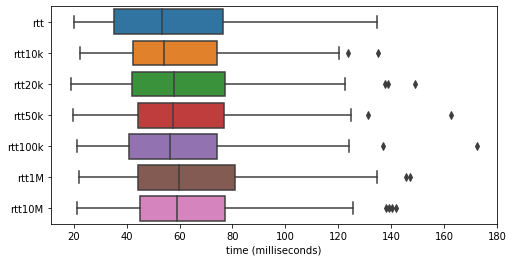

In [6]:
import seaborn as sns
import pandas as pd 
import matplotlib.pyplot as plt
df0 = pd.read_csv("../idp-castellotti-data/ping-bw-normal.csv")
df1 = pd.read_csv("../idp-castellotti-data/ping-bw-10k.csv")
df2 = pd.read_csv("../idp-castellotti-data/ping-bw-20k.csv")
df3 = pd.read_csv("../idp-castellotti-data/ping-bw-50k.csv")
df4 = pd.read_csv("../idp-castellotti-data/ping-bw-100k.csv")
df5 = pd.read_csv("../idp-castellotti-data/ping-bw-1M.csv")
df6 = pd.read_csv("../idp-castellotti-data/ping-bw-10M.csv")
df = pd.concat([df0, df1, df2, df3, df4, df5, df6], axis=1).reindex(df1.index)
plt.figure(figsize=(8, 4))
sns.boxplot(
    data=df[
        [
            "rtt",
            # "pop_ping_latency_ms",
            "rtt10k",
            # "pop_ping_latency_ms10k",
            "rtt20k",
            # "pop_ping_latency_ms20k",
            "rtt50k",
            # "pop_ping_latency_ms50k",
            "rtt100k",
            # "pop_ping_latency_ms100k",
            "rtt1M",
            # "pop_ping_latency_ms1M",
            "rtt10M",
            # "pop_ping_latency_ms10M",
        ]
    ],
    orient="h",
)
# plt.savefig("tex/tumbeamer/pics/rtt-iperf-stress.png")
plt.xlabel("time (milliseconds)")


plt.show()

In [ ]:
# this is how we get satellites for stalink constellation


